# Analysis of the average price for orders without market variables

This book serves to demonstrate the behaviour of Q-Learning and the influence of **time horizon** and **inventory** to the price which has to be paid over the course of filling **BUY** orders. No other market variables are being used to define the action space.

In [1]:
%cd ..

/Volumes/Data/dev/ctc-executioner


In [2]:
import numpy as np
from action_space import ActionSpace
from qlearn import QLearn
from order_side import OrderSide
from orderbook import Orderbook
from action_state import ActionState
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set(color_codes=True)

The training function updates the Q-Table according to the reward function (separate notebook on this).

In [3]:
def train(episodes=100):
    if not orderbook.getStates():
        orderbook.loadFromFile(trainBook)

    actionSpace.train(episodes=episodes, force_execution=False)
    np.save('q.npy', actionSpace.ai.q)
    return actionSpace.ai.q

A backtest runs orders on a historical data set. The result is a matrix M which defines the state (t, i) when the order was sent, the best ask price before execution, the chosen action levels and finally the resulted average price including a difference to the mentioned best price:
`M <- [t, i, Best Price, A, Paid Avg, Diff]`

In [4]:
def test(episodes=100, average=True):
    if not orderbook_test.getStates():
        orderbook_test.loadFromFile(testBook)

    q = np.load('q.npy').item()
    M = actionSpace_test.backtest(q, episodes, average=average)
    return M

We sum the price differences to the best ask price using the 4th element in the list containing our backtest results. For example:
`[[(100, 1.0, '{}'), 16105.5, [-15, -10, -5, -5, -2, 0], 16067.0, 38.5]]`
In this case the mid price was 16105.5 and the average price paid (accounting all the resulting trades) in order to fill the order of 1.0 BTC within 100 seconds was 16067.0, thus an advantage of $38.5 was achieved.

The list of these price differences can be illustrated in a histogram.

In [5]:
def calculate_profits(epochs):
    profits = []
    for i in range(epochs):
        M = test(1, average=False)
        M = np.array(M)
        profits.append(np.sum(M[0:, 4]))
    return profits


def hist_profit(episodes):
    x = calculate_profits(episodes)
    sns.distplot(x)
    plt.show()

We set up separate order books for both training and testing.
Furthermore, we specify the orders to be all BUY's and allow the Qlearn algorithm to explore orderbook levels reaching from -5 to +5 (e.g. 5 levels down in the buyer side or 5 levels up in the seller side respectively).

In [6]:
trainBook = 'query_result_train_15m.tsv'
testBook = 'query_result_test_15m.tsv'
orderbook = Orderbook(extraFeatures=False)
orderbook_test = Orderbook(extraFeatures=False)


side = OrderSide.BUY
levels = [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5, -6, -7, -10, -12, -15]
ai = QLearn(actions=levels, epsilon=0.4, alpha=0.3, gamma=0.8)

## Experiment 1: Time horizon

The first scenario we explore is to buy 1.0 BTC within 100 seconds, whereas segmentation of the order (cancel & post new) is allowed every 20 seconds with the remaining inventory at this point. Hence, we discretize the inventory in order to limit the action space (t, i). 

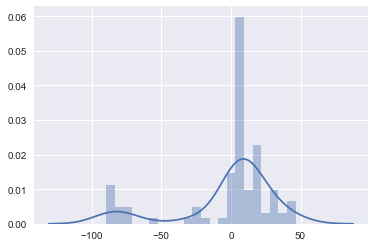

In [8]:
T = [0, 20, 40, 60, 80, 100]
T_test = [0, 20, 40, 60, 80, 100]
I = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
actionSpace = ActionSpace(orderbook, side, T, I, ai, levels)
actionSpace_test = ActionSpace(orderbook_test, side, T_test, I, ai, levels)

train(50)
hist_profit(100)

As we can see, we have done pretty good. The backtest resulted in an average price paid which is above 0, indicating that the steps taken by the actions were chosen wisely such that a profit can be made with this strategy. In addition a few outliers in the negative range occur, caused by orders which were not able to be filled during execution and had to be bought up with Market orders when the given time (t=100s) was consumed.

Let us now reduce the time horizon to 60 seconds and therefore the abiliy to interfere during the order execution by 2 steps, and forcing to execute the entire inventory quicker.

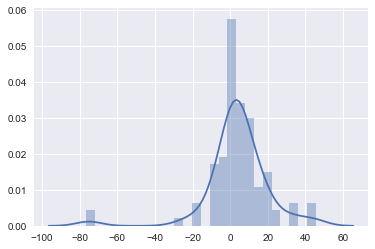

In [7]:
T = [0, 20, 40, 60]
T_test = [0, 20, 40, 60]
I = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
actionSpace = ActionSpace(orderbook, side, T, I, ai, levels)
actionSpace_test = ActionSpace(orderbook_test, side, T_test, I, ai, levels)

train(50)
hist_profit(100)

With less time availble, the paid prices more densley distributed, indicating that there is indeed less felxibility in terms of interfearing with the order flow. Furthermore, the mean price paid is lower, almost on pair with the best ask price.

In contrast, we now increase the time horizon to 140 seconds.

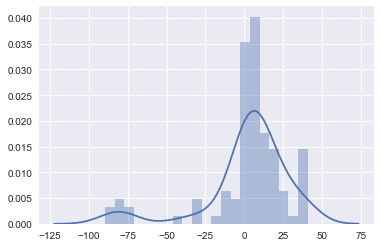

In [9]:
T = [0, 20, 40, 60, 80, 100, 120, 140]
T_test = [0, 20, 40, 60, 80, 100, 120, 140]
I = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
actionSpace = ActionSpace(orderbook, side, T, I, ai, levels)
actionSpace_test = ActionSpace(orderbook_test, side, T_test, I, ai, levels)

train(50)
hist_profit(100)

With a runtime of 140 seconds, market fluctuation becomes more dominant, resulting in more outlier trades in the negative price range but also in the profitable domain.
This behaviour provides inspiration that with short term direction movement predictions, the way of placing orders can be further exploited.

## Experiment 2: Inventory

We repeat experiment 1 but with less inventory required to be executed: 0.1 BTC in total.

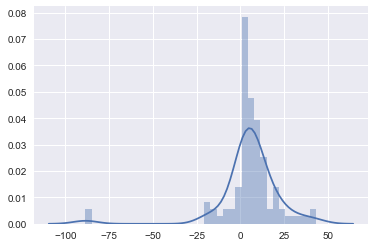

In [11]:
T = [0, 20, 40, 60, 80, 100]
T_test = [0, 20, 40, 60, 80, 100]
I = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
actionSpace = ActionSpace(orderbook, side, T, I, ai, levels)
actionSpace_test = ActionSpace(orderbook_test, side, T_test, I, ai, levels)

train(50)
hist_profit(100)

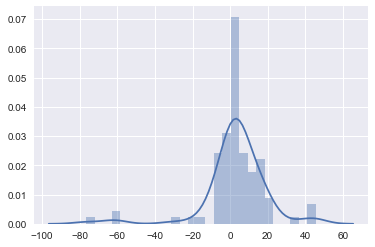

In [12]:
T = [0, 20, 40, 60]
T_test = [0, 20, 40, 60]
I = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
actionSpace = ActionSpace(orderbook, side, T, I, ai, levels)
actionSpace_test = ActionSpace(orderbook_test, side, T_test, I, ai, levels)

train(50)
hist_profit(100)

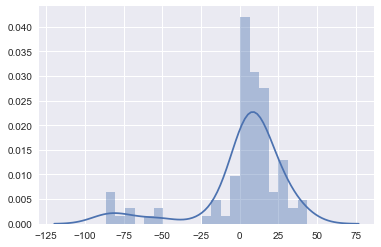

In [13]:
T = [0, 20, 40, 60, 80, 100, 120, 140]
T_test = [0, 20, 40, 60, 80, 100, 120, 140]
I = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
actionSpace = ActionSpace(orderbook, side, T, I, ai, levels)
actionSpace_test = ActionSpace(orderbook_test, side, T_test, I, ai, levels)

train(50)
hist_profit(100)

As we can see, the main pattern remains the same. However, the variance of prices being paid remain closer to the spread, indicating that less market orders had to be placed or that over the course of the order execution percentually larger parts could be filled leaving less to be executed on market. Thus, we conclude that the size of the inventory has a noticable impact on the price to be paid and is a signifiacnt factor of the number of order left unexecuted and to be filled with market orders.